In [1]:
import io
import os
import datetime
import random

import pandas as pd

import numpy as np
from numpy import mean
from numpy import std

# plots and visualizations
import pydot
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# sklearn
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# To ignore future version warnings for seaborn distplot.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fixing the seed in all libraries for reproducible results
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 
data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)
data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data
data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16'])

# Remove sampling weights (within and out of the experiment)
data = data.drop(columns='POIDS_SEL')

# Remove all the centered features
data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data
data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

# Remove additional features that seem to bring no value or are unclear in the methodology according to the original paper
data = data.drop(columns=['CV_hesit_', 'CV_hesit', 'CV_note_7p', 'ZetI', 'permis', 'CV_attrayant_'])

# Remove CV coding feature: CV_qualif -> adequate skills 
for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

data['CV_qualif_sup'] = data['CV_qualif_sup'].fillna(0)
data['CV_qualif_inf'] = data['CV_qualif_inf'].fillna(0)
data['PREN_MUSULMAN'] = data['PREN_MUSULMAN'].fillna(0)
data['ZUS_CUCS'] = data['ZUS_CUCS'].fillna(0)
data['recherche_TLD'] = data['recherche_TLD'].fillna(0)

data['etudes_etranger'] = data['etudes_etranger'].fillna(0)
data['langue_anglais'] = data['langue_anglais'].fillna(0)
data['langue_arabe'] = data['langue_arabe'].fillna(0)
data['langue_autres'] = data['langue_autres'].fillna(0)
data['CV_formation_'] = data['CV_formation_'].fillna(0)

# derived from CV_experience_3p
data['CV_experience_'] = data['CV_experience_'].fillna(0.5)

# fill with 1 since missing records are not in the other age groups
data['a26m'] = data['a26m'].fillna(1)

# Assign medium grade for all unknown records
data['CV_note_2'] = data['CV_note_2'].fillna(0)
data['CV_note_3'] = data['CV_note_3'].fillna(1)
data['CV_note_4'] = data['CV_note_4'].fillna(0)
data['CV_note_5'] = data['CV_note_5'].fillna(0)

for item in data:
    
    if data[item].isna().sum() > 0:
        print(item, data[item].isna().sum())
        
# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function
data = min_max_scaling(data)

# Create a dataframe for the anonymized and not anonymized data
X = pd.DataFrame()

# Upsampling the interviewed entries
for index, row in data.iterrows():
    if row['ENTRETIEN'] == 1:
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        
# Assign the interviewed column to our target vector
y = data['ENTRETIEN']

# Drop the Interviewed/hired & anonymized columns (hired is much dependent on the number of jobs available
# and will currently not be considered as target label)
X = data.drop(columns=['CVA', 'ENTRETIEN'])

CVA 203


In [6]:
# Train, Test split
# Fixed random seed for debugging to avoid random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
X_train.head()

,PREN_MUSULMAN,ZUS_CUCS,ZouI,FEMME,a50p,a3049,a26m,dip_aucun,dip_bepcap,dip_bac,...,service_nm,service_m,industrie,construction,cadre,profint,eoq,CDI,CNT_sup6m,poste_unique
992,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1165,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1426,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
102,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
572,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


In [7]:
# define the model
modelForest = RandomForestClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(modelForest, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Cross validation accuracy: %.2f%% (std: %.3f).' % (mean(n_scores)*100, std(n_scores)))

Cross validation accuracy: 97.92% (std: 0.009).


In [8]:
# get RF model predictions
modelForest.fit(X_train, y_train)
y_pred = modelForest.predict(X_test)

# Calculate and display accuracy
errors = sum(abs(y_pred - y_test))
accuracy = (len(y_pred)-errors)*100/len(y_pred)
print('Test-set accuracy: %.2f%%.' %accuracy)

Test-set accuracy: 98.44%.


In [9]:
# Extract single tree
estimator = modelForest.estimators_[5]

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns,
                class_names = ['notInterviewed', 'Interviewed'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)


(graph,) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')


# Display in jupyter notebook
# Image(filename = 'tree.png')

In [10]:
# Plots histogram of probability of being interviewed for both genders.
def plot_hist_prob(fem_prob, m_prob):
  # Sub-setting the interviewed class probability for the histogram.
  plt.figure(figsize=(6,4))
  plt.hist(fem_prob[:,0], bins=10, alpha=0.5, facecolor='r', label="Female")
  plt.hist(m_prob[:,0], bins=10, alpha=0.5, facecolor='b', label="Male")

  plt.xlabel("Probability", size=14)
  plt.ylabel("Count", size=14)
  plt.title("Female applicants interview prob. vs. male applicants")
  plt.legend(loc='upper right')
  # plt.savefig("hiring_prob_initial_model.png")

In [11]:
# Computes the difference between interview probability for each sample when
# the gender field is set to female vs. male (0 means no difference, +ve means
# higher probability when the field was set to male, and vice versa).
# Plots density of this difference.
def plot_density_prob_diff(fem_prob, m_prob):
  # number of times where being a male increased the interview probability.
  diff = (m_prob[:,0]-fem_prob[:,0])
  x0 = -0.3
  x1 = 0.3

  #plotting the PDF (do this before plotting anything else)
  ax = sns.distplot(diff, hist=False,color='b')
  kde_x, kde_y = ax.lines[0].get_data()

  #plotting the two lines
  p1 = plt.axvline(x=x0,color='r')
  p2 = plt.axvline(x=x1,color='r')


  ax.fill_between(kde_x, kde_y, where=(kde_x<x0) | (kde_x>x1) , 
                  interpolate=True, color='r')


  ax.set_yticks(ticks=np.arange(0,2.5,0.1),minor=True)
  # Add the grid
  ax.grid(which='minor', axis='y', linestyle='-')
  ax.grid(which='major', axis='y', linestyle='-')
  ax.set_xlim(-1.5,1.5)
  ax.set_ylim(0,2.5)

  plt.xlabel("(male interview prob.) - (female interview prob.)", size=14)
  plt.ylabel("Density", size=14)
  plt.title("Density plot of difference in interview prob.")
  plt.text(-1, 0.4, ("Female > Male\n%d" % sum(diff < -0.3)),horizontalalignment='center')
  plt.text(1, 0.4, ("Male > Female\n%d" % sum(diff > 0.3)),horizontalalignment='center')
  plt.text(0, 0.4, ("Male\n≈\nFemale\n%d" % (diff.shape[0]-sum(diff < -0.3)-sum(diff > 0.3))), horizontalalignment='center')

  plt.show()

# plot_density_prob_diff(fem_prob, m_prob)

In [12]:
# copying the male applicants rows and changing the gender field to female
fem_test = X_test[X_test['FEMME']==0].copy()
n_males = fem_test.shape[0]
fem_test = fem_test.assign(FEMME=1)
# appending the female applicants rows
fem_test = fem_test.append(X_test[X_test['FEMME']==1].copy())

# copy the male applicants rows
m_test = X_test[X_test['FEMME']==0].copy()
# appending the female applicants rows and changing the gender field to male
m_test = m_test.append(X_test[X_test['FEMME']==1].copy())
m_test = m_test.assign(FEMME=0)

### Plot difference in RF probabilities
TODO check if this subsection is confusing and delete it

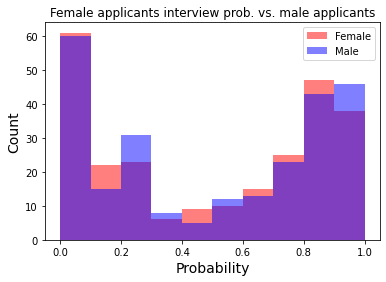

In [13]:
# get predictions probability for the interviewed class, for both data-subsets
fem_prob = modelForest.predict_proba(fem_test)
m_prob = modelForest.predict_proba(m_test)

plot_hist_prob(fem_prob, m_prob)

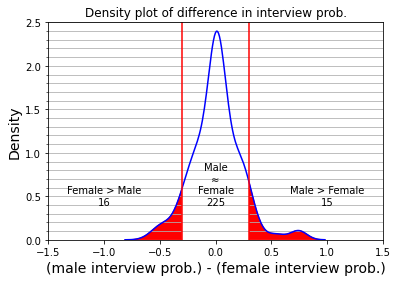

In [14]:
plot_density_prob_diff(fem_prob, m_prob)